# Neural Networks: Pinnacle Bank Churn Prediction Model

### Context

**Pinnacle Bank**, a financial institution in the American South, is interested in exploring the problem of **"customer churn" i.e. cessation of customer banking activity in lieu of a different banking provider**. It is important to understand which aspects of a bank's service influence a customer's decision to leave their existing banking provider. By identifying different factors that play a role in customer churn, management at **Pinnacle Bank** can make targeted improvements to customer-facing services in order to retain customers long term and generate profit. 

### Objective

Build a neural network based classifier that can determine whether or not a customer will leave the bank (churn) in the next 6 months.

### Tools Used

* **Exploratory Data Analysis (EDA)**
* **Data Cleaning / Preprocessing**
* **Tensorflow**
* **Keras**
* **Artificial Neural Networks (ANNs)**
* **Regularization**
* **Business Analysis & Recommendations**

### Data Dictionary

* `CustomerId`: Unique customer ID

* `Surname`: Customer's last name

* `CreditScore`: Customer's credit score
  
* `Geography`: Customer's geographical location
   
* `Gender`: Customer's gender
   
* `Age`: Customer's age (in years)
    
* `Tenure`: Length of time customer has owned an account at Pinnacle Bank (in years)

* `NumOfProducts`: Number of products that a customer has purchased through the bank

* `Balance`: Customer account balance

* `HasCrCard`: Categorical variable indicating whether or not customer owns a credit card (0 = Does Not Own a Credit Card, 1 = Owns a Credit Card)

* `EstimatedSalary`: Customer's estimated salary

* `isActiveMember`: Categorical variable indicating whether or not the customer is an active member of Pinnacle Bank. "Active member" meaning the customer uses bank products regularly / makes regular transactions, etc (0 = Not an Active Member, 1 = Active Member)

* `Exited`: Categorical variable indicating whether or not the customer left the bank within the last 6 months (0 = Did Not Leave the Bank, 1 = Left the Bank)

## Importing necessary libraries

In [1]:
# Libraries to read and manipulate data

import pandas as pd
import numpy as np

# Libraries to help with data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Library to split data

from sklearn.model_selection import train_test_split

# Library to standardize the data

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Libraries with different functions to build models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import backend
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Library to apply SMOTE

from imblearn.over_sampling import SMOTE

# Library to display model metrics

from sklearn.metrics import confusion_matrix, roc_curve, classification_report, recall_score, precision_recall_curve

from collections import Counter

import random

# Library to suppress warnings

import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [2]:
# Use the .read_csv function to load the dataset

churn = pd.read_csv("Pinnacle_Bank_Customer_Churn.csv")

## Data Overview

In [3]:
# Use the .shape function to display the number of rows and columns present in the dataset

churn.shape 

(10000, 14)

#### Observations:

There are **10,000 rows** and **14 columns** present in the dataset.

In [4]:
# Create a copy of the dataset as a DataFrame to preserve quality of the original dataset

data = churn.copy()

In [5]:
# Use the .head function to view the first 5 rows of the DataFrame

data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Observations:



In [ ]:
# Use the .tail function to view the final 5 rows of the DataFrame

data.tail()

#### Observations:



In [ ]:
# Use the .info function to generate an overview of the DataFrame

data.info()

#### Observations:

The dataset contains **9 integer columns**, **3 object columns**, and **2 float columns**.

In [ ]:
# Use the .isnull function to detect missing values in DataFrame and use the sum function to total the missing values

missing_values = data.isnull().sum()
missing_values

#### Observations:

The dataset posesses **no missing values.**

In [ ]:
# Use the .describe function to generate a description of the data in our DataFrame

data.describe().T

In [ ]:
# Use the .drop function to drop the "RowNumber," "CustomerId," and "Surname" columns containing unique values not relevant to analysis

data = data.drop(columns=['CustomerId','RowNumber','Surname'])

## Exploratory Data Analysis

### Univariate Analysis

In [ ]:
# Function to display a boxplot and a histogram along the same scale

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="cornflowerblue"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [ ]:
# Function to display labeled barplots

def labeled_barplot(data, feature, perc=False, n=None, palette="crest"):
    """
    Customized barplot with percentage at the top and customizable color palette.

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    palette: color palette (default is "coolwarm")
    """

    total = len(data[feature])  # Length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=45, fontsize=12)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette=palette,
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(100 * p.get_height() / total)
        else:
            label = p.get_height()

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
            color="blue"  # Changing the annotation text color
        )

    plt.xlabel("Category")  # Custom X-axis label
    plt.ylabel("Count")  # Custom Y-axis label
    plt.title("Bar Plot of " + feature)  # Custom plot title
    plt.show()

### Credit Score of Customer

In [ ]:
histogram_boxplot(data,'CreditScore')

#### Observations:

**Distribution:** The histogram shows a **fairly normal distribution with a slight left skew**. Most customers have credit scores around the central peak, which suggests a moderate creditworthiness among the bank's clientele.

**Outliers:** The box plot does not indicate significant outliers in the credit score data. The **distribution is fairly consistent across the range**.

### Age of Customer

In [ ]:
histogram_boxplot(data,'Age')

#### Observations:

**Distribution:** The histogram for Age shows a **right-skewed distribution**. **Most customers are younger**, with a **significant number in their 30s to early 40s**.

**Outliers:** The box plot for Age indicates the **presence of outliers on the upper range, with some customers significantly older than the median age group**.

### Total Balance of Customer

In [ ]:
histogram_boxplot(data,'Balance')

#### Observations:

**Distribution:** The histogram for Balance shows a **bimodal distribution**. A **substantial proportion of customers have a zero balance, which could indicate inactive accounts or new accounts**. The other peak around the median suggests active accounts.

**Outliers:** The box plot doesn't show any significant outliers for Balance. The **distribution is quite uniform for non-zero balances**.

### Estimated Salary of Customer

In [ ]:
histogram_boxplot(data,'EstimatedSalary')

#### Observations:

**Distribution:** The histogram for estimated salary is quite uniform, showing an **almost perfect uniform distribution across all salary ranges**. This suggests that **salary varies widely among the bank’s clientele without any specific concentration**.

**Outliers:** There are **no apparent outliers in the estimated salary** data as per the box plot, and the **data is evenly spread across the salary range**.

### Customer Country of Residence

In [ ]:
labeled_barplot(data, "Geography", perc=True)

#### Observations:

A majority of the customers are from France, followed by Spain and Germany. This indicates that **the bank's primary market is France.**

### Gender of Customer

In [ ]:
labeled_barplot(data, "Gender", perc=True)

#### Observations:

There is a **relatively balanced distribution between male and female customers**, with a slight dominance of male customers.

### Tenure of Customer

In [ ]:
labeled_barplot(data, "Tenure", perc=True)

#### Observations:

Customers are fairly evenly distributed across different tenure lengths from 0 to 10 years. **This suggests a steady acquisition and retention of customers over time.**

### Number of Products Owned by Customer

In [ ]:
labeled_barplot(data, "NumOfProducts", perc=True)

#### Observations:

**Most customers have 1 or 2 products from the bank**. There are very few customers with 3 or 4 products, indicating that **most customers prefer a simpler banking setup.**

### Credit Card Ownership of Customer

In [ ]:
labeled_barplot(data, "HasCrCard", perc=True)

#### Observations:

A large proportion of the bank's customers have a credit card, showing that **credit cards are a popular product among the bank’s clientele.**

### Membership Status of Customer

In [ ]:
labeled_barplot(data, "IsActiveMember", perc=True)

#### Observations:

The **customers are nearly evenly split between active and inactive statuses**, though there's a **slight majority of active members.**

### Churn Status of Customer

In [ ]:
labeled_barplot(data, "Exited", perc=True)

#### Observations:

The **majority of customers have not exited (churned), indicating a lower overall churn rate in the dataset**. However, there is a **significant minority of customers who have exited**, showing that **churn is a notable concern for the bank.**

## Bivariate Analysis

### Correlation Check

In [ ]:
# Display heatmap of correlations between variables in the dataset

plt.figure(figsize=(15, 7))
sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

### Churn Status by Credit Score of Customer

In [ ]:
ax = sns.boxplot(x='Exited', y='CreditScore', data=data, palette='viridis')
ax.set_title('Credit Score Distribution by Churn Status')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Credit Score')
ax.set_xticklabels(['Current Customer', 'Churned Customer'])  

plt.show()

#### Observations:

**There doesn't appear to be a significant difference in the credit score distribution between customers who exited and those who did not.** Both groups show similar median credit scores and interquartile ranges. **This suggests that credit score alone might not be a strong indicator of churn.**

### Churn Status by Age of Customer

In [ ]:
ax = sns.boxplot(x='Exited', y='Age', data=data, palette='viridis')
ax.set_title('Customer Age (In Years) by Churn Status')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Age')
ax.set_xticklabels(['Current Customer', 'Churned Customer'])  

plt.show()

#### Observations: 

Age shows a notable difference between the two groups. **Customers who exited tend to be older than those who stayed.** The **median age of churned customers is noticeably higher, and the age distribution is wider**, indicating that **older customers are more likely to churn.**

### Churn Status by Tenure of Customer

In [ ]:
ax = sns.boxplot(x='Exited', y='Tenure', data=data, palette='viridis')
ax.set_title('Customer Tenure (In Years) by Churn Status')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Tenure')
ax.set_xticklabels(['Current Customer', 'Churned Customer'])

plt.show()

#### Observations: 

**Tenure distributions are quite similar for both groups**, although there is a **slight indication that customers with very low tenure (close to 0 years) and very high tenure (close to 10 years) might be more likely to stay**. The **middle range of tenure shows less distinction in churn**.

### Churn Status by Account Balance of Customer (In Dollars)

In [ ]:
ax = sns.boxplot(x='Exited', y='Balance', data=data, palette='viridis')
ax.set_title('Customer Account Balance (In Dollars) by Churn Status')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Account Balance')
ax.set_xticklabels(['Current Customer', 'Churned Customer']) 

plt.show()

#### Observations: 

The balance shows a significant difference between the churned and non-churned customers. **Customers with higher balances are more likely to churn**, indicated by a higher median and a broader range in the balance for those who exited. **Customers with zero balance seem less likely to churn**, which is evident from the dense cluster at the balance of zero for non-churned customers.

### Churn Status by Estimated Salary of Customer (In Dollars)

In [ ]:
ax = sns.boxplot(x='Exited', y='EstimatedSalary', data=data, palette='viridis')
ax.set_title('Estimated Salary (In Dollars) by Churn Status')
ax.set_xlabel('Churn Status')
ax.set_ylabel('Estimated Salary')
ax.set_xticklabels(['Current Customer', 'Churned Customer'])  

plt.show()

#### Observations: 

There is no clear trend in estimated salary with respect to churn. Both groups show similar distributions in terms of median salary and spread, suggesting that **salary alone may not be a good predictor of churn.**

### Churn Status by Customer Country of Residence

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='Geography', hue='Exited', data=data, edgecolor="black",palette='viridis')

ax.set_title('Churn Status by Country of Residence')  # Setting the plot title
ax.set_xlabel('Country of Residence')  # Set the x-axis label
ax.set_ylabel('Count')  # Removing the y-axis label
ax.legend(title='Exited', loc='upper right')  # Adjusting the legend
ax.set_xticklabels(['France', 'Spain', 'Germany'])  # Custom labels for the x-axis
ax.legend(['Current Customer', 'Churned Customer'], title='Churn Status', loc='upper right')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations: 

The churn rate varies significantly across different geographical regions. **Customers from Germany have a notably higher churn rate compared to those from France and Spain**. This suggests that **regional factors or market conditions in Germany might be influencing customer satisfaction or preferences differently**.

### Churn Status by Gender of Customer

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x=data['Gender'], hue='Exited', data=data, edgecolor="black", palette='viridis')

ax.set_title('Churn Status by Gender of Customer')  
ax.set_xlabel('Gender')  
ax.set_ylabel('Count')  
ax.legend(title='Exited', loc='upper right')  
ax.set_xticklabels(['Female', 'Male']) 
ax.legend(['Current Customer', 'Churned Customer'], title='Churn Status', loc='upper right')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations: 

There is a **noticeable difference in churn rates between genders**. **Female customers have a higher churn rate compared to male customers**. This difference could be indicative of varying experiences or expectations between genders regarding the bank's services.

### Churn Status by Number of Products Owned by Customer

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='NumOfProducts', hue='Exited', data=data, edgecolor="black", palette='viridis')

ax.set_title('Churn Status by Number of Products Owned by Customer') 
ax.set_xlabel('Number of Products Owned') 
ax.set_ylabel('Count')  
ax.legend(title='Exited', loc='upper right')  
ax.legend(['Current Customer', 'Churned Customer'], title='Churn Status', loc='upper right')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations: 

The **number of products a customer has with the bank shows a strong correlation with churn**. **Customers with 1 or 2 products have lower churn rates compared to those with 3 or 4 products**. Particularly, **customers with 3 products have a very high churn rate**, suggesting possible issues with service complexity or product satisfaction.

### Churn Status by Credit Card Ownership of Customer

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='HasCrCard', hue='Exited', data=data, edgecolor="black", palette='viridis')

ax.set_title('Churn Status by Customer Credit Card Ownership')  
ax.set_xlabel('Credit Card Ownership')  
ax.set_ylabel('Count')  
ax.legend(title='Exited', loc='upper right')  
ax.set_xticklabels(['Does Not Own Credit Card', 'Owns Credit Card'])  
ax.legend(['Current Customer', 'Churned Customer'], title='Churn Status', loc='upper right')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations: 

There seems to be a slight difference in churn rates between customers who have a credit card and those who do not, but the difference is not as pronounced as other variables. **This indicates that merely possessing a credit card does not significantly influence the decision to leave the bank.**

### Churn Status by Active / Inactive Customers

In [ ]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x='IsActiveMember', hue='Exited', data=data, edgecolor="black", palette='viridis')
ax.set_title('Churn Status by Member Status of Customer')  
ax.set_xlabel('Member Status')  
ax.set_ylabel('Count')  
ax.legend(title='Exited', loc='upper right')  
ax.set_xticklabels(['Inactive', 'Active'])  
ax.legend(['Current Customer', 'Churned Customer'], title='Customer Status', loc='upper right')

# Add number totals above the bar for each class

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.tight_layout()
plt.show()

#### Observations: 

**Active membership status is strongly associated with churn.** Inactive members have a much higher churn rate compared to active members. This suggests that **engagement and regular interaction with the bank’s services are crucial in retaining customers.**

## Data Preprocessing

In [6]:
# Encode categorical variables using label encoder

label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])

In [7]:
# Separate features and target

X = data.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = data['Exited']

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  int64  
 2   Gender           10000 non-null  int64  
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [9]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10


In [10]:
X.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9995,771,0,1,39,5,0.00,2,1,0,96270.64
9996,516,0,1,35,10,57369.61,1,1,1,101699.77
9997,709,0,0,36,7,0.00,1,0,1,42085.58
9998,772,1,1,42,3,75075.31,2,1,0,92888.52
9999,792,0,0,28,4,130142.79,1,1,0,38190.78


In [ ]:




# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and validation sets before applying SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y)

### Data Normalization

In [12]:
# Initialize the StandardScaler

scaler = StandardScaler()

# Fit the scaler to the dataset and transform it

X_scaled = scaler.fit_transform(X)

# Check the first few rows of the scaled dataset

print(X_scaled[:5])

[[-0.32622142 -0.90188624 -1.09598752  0.29351742 -1.04175968 -1.22584767
  -0.91158349  0.64609167  0.97024255  0.02188649]
 [-0.44003595  1.51506738 -1.09598752  0.19816383 -1.38753759  0.11735002
  -0.91158349 -1.54776799  0.97024255  0.21653375]
 [-1.53679418 -0.90188624 -1.09598752  0.29351742  1.03290776  1.33305335
   2.52705662  0.64609167 -1.03067011  0.2406869 ]
 [ 0.50152063 -0.90188624 -1.09598752  0.00745665 -1.38753759 -1.22584767
   0.80773656 -1.54776799 -1.03067011 -0.10891792]
 [ 2.06388377  1.51506738 -1.09598752  0.38887101 -1.04175968  0.7857279
  -0.91158349  0.64609167  0.97024255 -0.36527578]]


#### Observations:

The dataset has been scaled and can now be split into train / validation / test.

### Train-Validation-Test Split

In [13]:
# Split the data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, 
                                                  test_size=0.2, 
                                                  random_state=1, 
                                                  stratify=y)

In [14]:
# Splitting remaining data into validation and test sets (50% each of remaining data)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, 
                                                test_size=0.5, 
                                                random_state=1)

In [15]:
# Checking the size of each dataset

X_train.shape, X_val.shape, X_test.shape

((8000, 10), (1000, 10), (1000, 10))

#### Observations:

**Training, validation, and test data has been prepared** and **exists as 10x8000, 10x1000, and 10x1000 datasets** ready for normalization.

## Model Building

### Model Evaluation Criterion

Given that the cost of failing to identify a customer who is likely to churn (false negative) could be higher than mistakenly identifying a customer as likely to churn (false positive), **focusing on recall is particularly important.** However, since excessive targeting of customers who are not at risk can also incur costs, maintaining a balance (as reflected by the F1-score and other metrics) could yield valuable insights.

In [16]:
def make_confusion_matrix(actual_targets, predicted_targets):
    """
    To plot the confusion_matrix with percentages

    actual_targets: actual target (dependent) variable values
    predicted_targets: predicted target (dependent) variable values
    """
    cm = confusion_matrix(actual_targets, predicted_targets)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(cm.shape[0], cm.shape[1])

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [17]:
train_metric_df = pd.DataFrame(columns=["recall"])
valid_metric_df = pd.DataFrame(columns=["recall"])

In [18]:
# Check the distribution of classes in training, validation, and test sets

print(f"Training set: {Counter(y_train)}")
print(f"Validation set: {Counter(y_val)}")
print(f"Test set: {Counter(y_test)}")

Training set: Counter({0: 6370, 1: 1630})
Validation set: Counter({0: 803, 1: 197})
Test set: Counter({0: 790, 1: 210})


### Neural Network with SGD Optimizer

In [19]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [20]:
# Initializing the neural network

model_0 = Sequential()

# Input layer consisting of 11 neurons

model_0.add(Dense(11, activation='relu', input_dim = X_train.shape[1]))

# First hidden layer consisting of 64 neurons

model_0.add(Dense(64, activation='relu'))

# Second hidden layer consisting of 64 neurons

model_0.add(Dense(32, activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_0.add(Dense(1, activation = 'sigmoid'))

In [21]:
# Stochastic gradient descent will be used as the optimizer on this initial model with its learning rate set to 0.001

optimizer = tf.keras.optimizers.SGD(0.001)

metric = keras.metrics.Recall()

In [22]:
# Compile the model with binary cross entropy as loss function and recall as the metric

model_0.compile(optimizer=optimizer,
                loss='binary_crossentropy',  # Appropriate loss function for binary classification
                metrics=[metric])

In [23]:
# Display a summary of the structure of the model with number of total layers and parameters

model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dense_1 (Dense)             (None, 64)                768       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,002
Trainable params: 3,002
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fit the model to the training data across 50 epochs

history_0 = model_0.fit(X_train, y_train,
                      epochs=300,
                      batch_size=32,  
                      validation_data=(X_val, y_val),
                      verbose=1)

Epoch 1/300
168/250 [===================>..........] - ETA: 0s - loss: 0.6505 - recall: 0.1332 

2024-06-11 13:24:00.804666: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 0s 595us/step - loss: 0.6423 - recall: 0.0908 - val_loss: 0.6196 - val_recall: 0.0000e+00
Epoch 2/300
250/250 [==============================] - 0s 316us/step - loss: 0.5990 - recall: 0.0000e+00 - val_loss: 0.5815 - val_recall: 0.0000e+00
Epoch 3/300
250/250 [==============================] - 0s 317us/step - loss: 0.5668 - recall: 0.0000e+00 - val_loss: 0.5531 - val_recall: 0.0000e+00
Epoch 4/300
250/250 [==============================] - 0s 301us/step - loss: 0.5430 - recall: 0.0000e+00 - val_loss: 0.5319 - val_recall: 0.0000e+00
Epoch 5/300
250/250 [==============================] - 0s 295us/step - loss: 0.5257 - recall: 0.0000e+00 - val_loss: 0.5165 - val_recall: 0.0000e+00
Epoch 6/300
250/250 [==============================] - 0s 302us/step - loss: 0.5135 - recall: 0.0000e+00 - val_loss: 0.5056 - val_recall: 0.0000e+00
Epoch 7/300
250/250 [==============================] - 0s 330us/step - loss: 0.5050 - recall: 0.0000e+00 - val_loss: 0.497

#### Loss Function

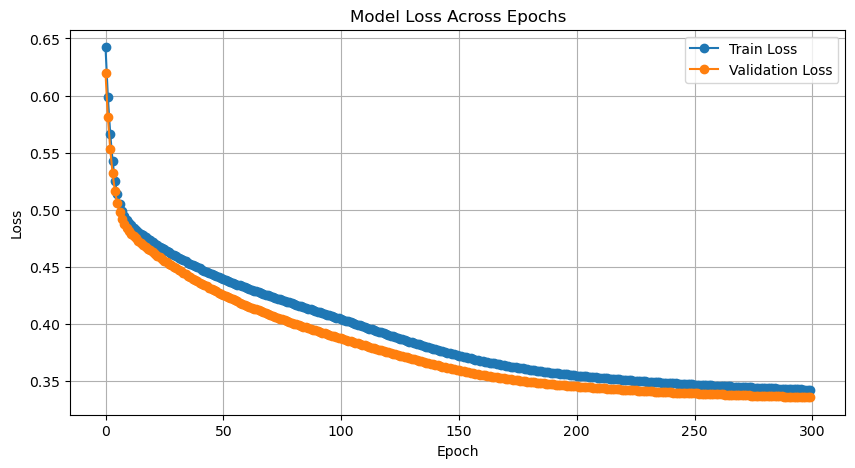

In [25]:
# Plotting train loss vs validation loss

plt.figure(figsize=(10, 5))
plt.plot(history_0.history['loss'], 'o-', label='Train Loss')
plt.plot(history_0.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

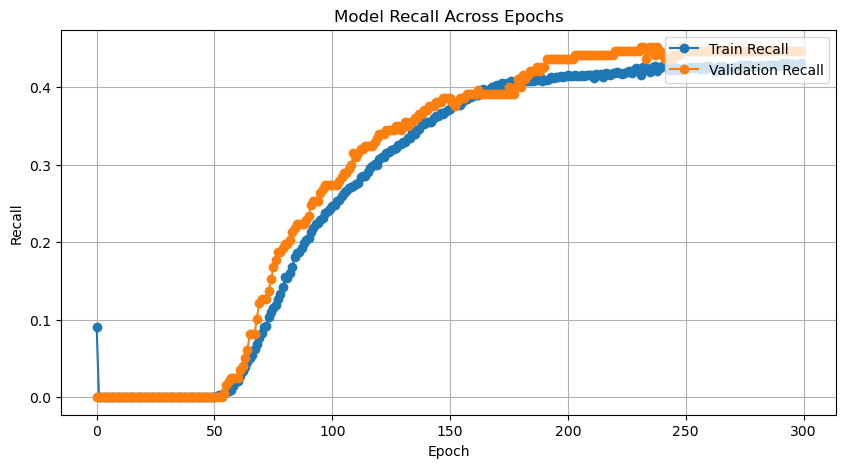

In [26]:
# Plotting train recall vs validation recall

plt.figure(figsize=(10, 5))
plt.plot(history_0.history['recall'], 'o-', label='Train Recall')
plt.plot(history_0.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [27]:
# Predicting the training data outcomes and displaying the first 10 outcomes

y_train_pred = model_0.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

250/250 [==============================] - 0s 263us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [28]:
# Predicting the validation data outcomes and displaying the first 10 outcomes

y_val_pred = model_0.predict(X_val)
y_val_pred = (y_val_pred > 0.5)  
print(y_val_pred[:10])

32/32 [==============================] - 0s 391us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [29]:
model_name = "NN with SGD"

train_metric_df.loc[model_name] = recall_score(y_train, y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val, y_val_pred)

In [30]:
# Classification report for model performance on training data

cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6370
           1       0.76      0.43      0.55      1630

    accuracy                           0.86      8000
   macro avg       0.81      0.70      0.73      8000
weighted avg       0.85      0.86      0.84      8000



In [31]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       803
           1       0.79      0.45      0.57       197

    accuracy                           0.87      1000
   macro avg       0.83      0.71      0.75      1000
weighted avg       0.86      0.87      0.85      1000



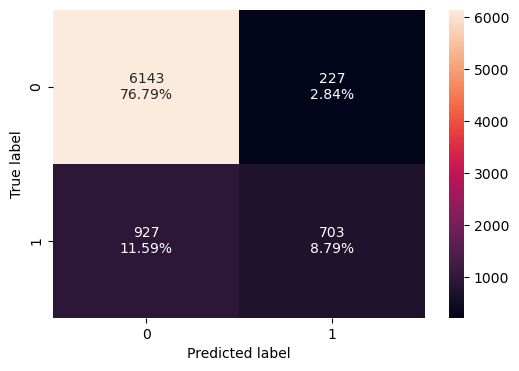

In [32]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train, y_train_pred)

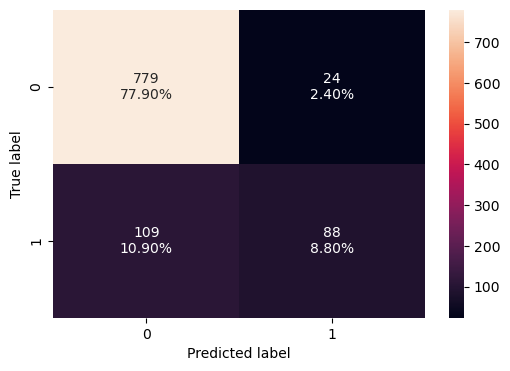

In [33]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

## Model Performance Improvement

### Neural Network with Adam Optimizer

In [34]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [35]:
# Initializing the neural network

model_1 = Sequential()

# Input layer consisting of 11 neurons

model_1.add(Dense(11, activation='relu', input_dim = X_train.shape[1]))

# First hidden layer consisting of 64 neurons

model_1.add(Dense(64, activation='relu'))

# Second hidden layer consisting of 32 neurons

model_1.add(Dense(32, activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_1.add(Dense(1, activation = 'sigmoid'))

In [36]:
# Adam will be used as the optimizer for this second model with its learning rate set to 0.001

optimizer = Adam(learning_rate=0.001)

metric = keras.metrics.Recall()

In [37]:
# Compile the model with binary cross entropy as loss function and recall as the metric

model_1.compile(optimizer=optimizer,
                loss='binary_crossentropy',  
                metrics=[metric])

In [38]:
# Display a summary of the structure of the model with number of total layers and parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dense_1 (Dense)             (None, 64)                768       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,002
Trainable params: 3,002
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Fit the model to the training data across 50 epochs

history_1 = model_1.fit(X_train, y_train,
                      epochs=25,
                      batch_size=32,  
                      validation_data=(X_val, y_val),
                      verbose=1)

Epoch 1/25
250/250 [==============================] - 0s 730us/step - loss: 0.4672 - recall: 0.0583 - val_loss: 0.4021 - val_recall: 0.1980
Epoch 2/25
250/250 [==============================] - 0s 528us/step - loss: 0.4024 - recall: 0.2847 - val_loss: 0.3668 - val_recall: 0.3503
Epoch 3/25
250/250 [==============================] - 0s 532us/step - loss: 0.3706 - recall: 0.3748 - val_loss: 0.3489 - val_recall: 0.3858
Epoch 4/25
250/250 [==============================] - 0s 520us/step - loss: 0.3555 - recall: 0.4166 - val_loss: 0.3441 - val_recall: 0.4619
Epoch 5/25
250/250 [==============================] - 0s 506us/step - loss: 0.3494 - recall: 0.4288 - val_loss: 0.3391 - val_recall: 0.3706
Epoch 6/25
250/250 [==============================] - 0s 531us/step - loss: 0.3457 - recall: 0.4405 - val_loss: 0.3384 - val_recall: 0.4010
Epoch 7/25
250/250 [==============================] - 0s 532us/step - loss: 0.3433 - recall: 0.4571 - val_loss: 0.3326 - val_recall: 0.4365
Epoch 8/25
250/250 [

#### Loss Function

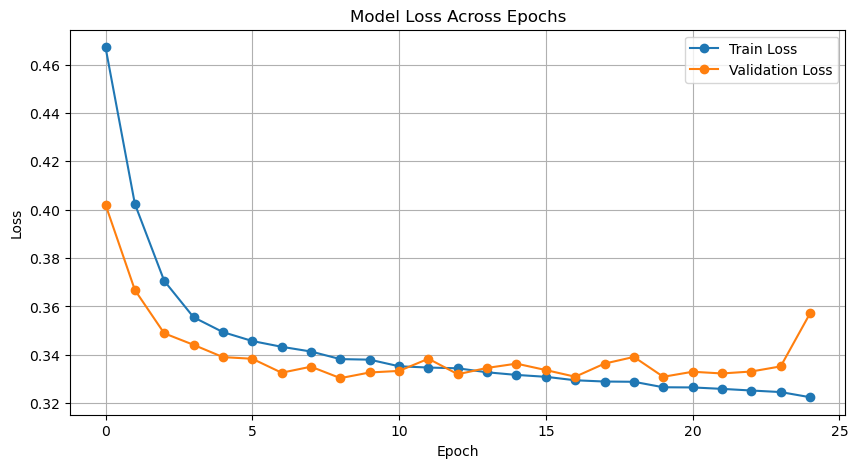

In [40]:
# Plotting train loss vs validation loss

plt.figure(figsize=(10, 5))
plt.plot(history_1.history['loss'], 'o-', label='Train Loss')
plt.plot(history_1.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

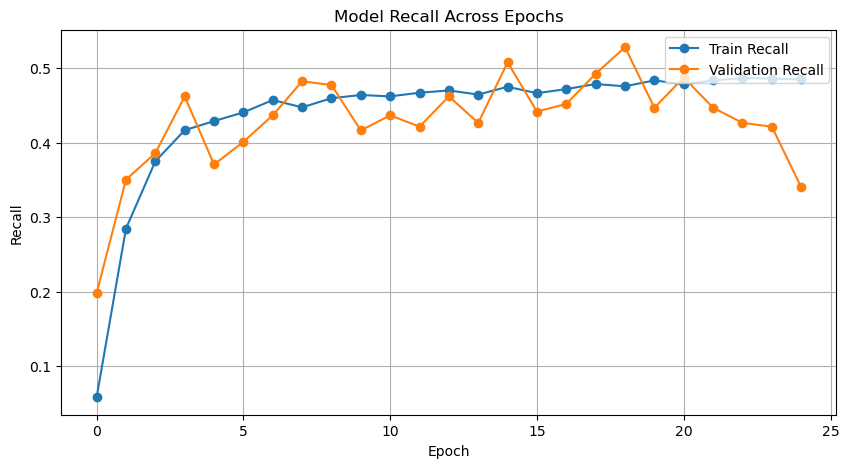

In [41]:
# Plotting train recall vs validation recall

plt.figure(figsize=(10, 5))
plt.plot(history_1.history['recall'], 'o-', label='Train Recall')
plt.plot(history_1.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [42]:
# Predicting the training data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_train_pred = model_1.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

250/250 [==============================] - 0s 231us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [43]:
# Predicting the validation data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_val_pred = model_1.predict(X_val)
y_val_pred = (y_val_pred > 0.5)  
print(y_val_pred[:10])

32/32 [==============================] - 0s 345us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [44]:
model_name = "NN with Adam"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [45]:
# Classification report for model performance on training data

cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6370
           1       0.89      0.37      0.52      1630

    accuracy                           0.86      8000
   macro avg       0.88      0.68      0.72      8000
weighted avg       0.87      0.86      0.84      8000



In [46]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       803
           1       0.92      0.34      0.50       197

    accuracy                           0.86      1000
   macro avg       0.89      0.67      0.71      1000
weighted avg       0.87      0.86      0.84      1000



#### Confusion Matrix

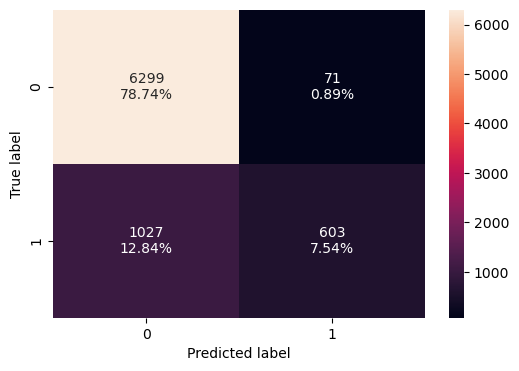

In [47]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train, y_train_pred)

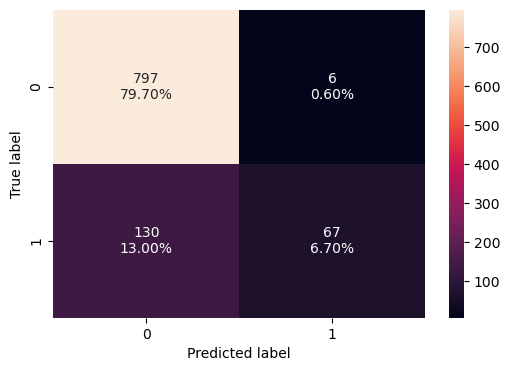

In [48]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

### Neural Network with Adam Optimizer and Dropout

In [49]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [50]:
# Initializing the neural network

model_2 = Sequential()

# Input layer consisting of 11 neurons

model_2.add(Dense(11, activation='relu', input_dim = X_train.shape[1]))

# Dropout of 0.2 for input layer

model_2.add(Dropout(0.2))

# First hidden layer consisting of 128 neurons

model_2.add(Dense(128, activation='relu'))

# Second hidden layer consisting of 64 neurons

model_2.add(Dense(64, activation='relu'))

# Dropout of 0.2 after second hidden layer

model_2.add(Dropout(0.2))

# Third hidden layer consisting of 32 neurons

model_2.add(Dense(32, activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_2.add(Dense(1, activation = 'sigmoid'))

In [51]:
# Adam will be used as the optimizer for this third model with its learning rate set to 0.001

optimizer = Adam(learning_rate=0.001)

metric = keras.metrics.Recall()

In [52]:
# Compile the model with binary cross entropy as loss function and recall as the metric

model_2.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=[metric])

In [53]:
# Display a summary of the structure of the model with number of total layers and parameters

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               1536      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 3

In [54]:
# Fit the model to the training data across 100 epochs

history_2 = model_2.fit(X_train, y_train,
                      epochs=100,
                      batch_size=32,  
                      validation_data=(X_val, y_val),
                      verbose=1)

Epoch 1/100
250/250 [==============================] - 0s 808us/step - loss: 0.4855 - recall: 0.0356 - val_loss: 0.4169 - val_recall: 0.0457
Epoch 2/100
250/250 [==============================] - 0s 656us/step - loss: 0.4427 - recall: 0.1454 - val_loss: 0.3867 - val_recall: 0.2081
Epoch 3/100
250/250 [==============================] - 0s 629us/step - loss: 0.4193 - recall: 0.2656 - val_loss: 0.3668 - val_recall: 0.3350
Epoch 4/100
250/250 [==============================] - 0s 621us/step - loss: 0.3989 - recall: 0.3018 - val_loss: 0.3527 - val_recall: 0.4264
Epoch 5/100
250/250 [==============================] - 0s 625us/step - loss: 0.3936 - recall: 0.3252 - val_loss: 0.3572 - val_recall: 0.2792
Epoch 6/100
250/250 [==============================] - 0s 630us/step - loss: 0.3832 - recall: 0.3528 - val_loss: 0.3482 - val_recall: 0.3350
Epoch 7/100
250/250 [==============================] - 0s 634us/step - loss: 0.3823 - recall: 0.3564 - val_loss: 0.3483 - val_recall: 0.3452
Epoch 8/100
2

#### Loss Function

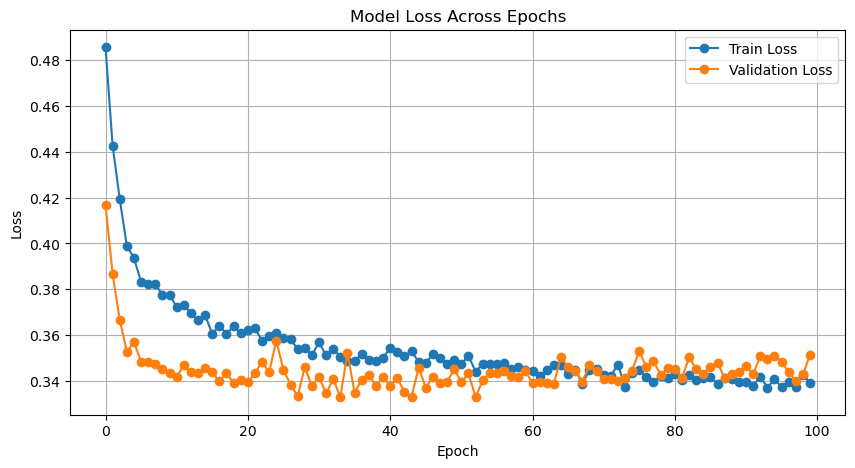

In [55]:
# Plotting train loss vs validation loss

plt.figure(figsize=(10, 5))
plt.plot(history_2.history['loss'], 'o-', label='Train Loss')
plt.plot(history_2.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

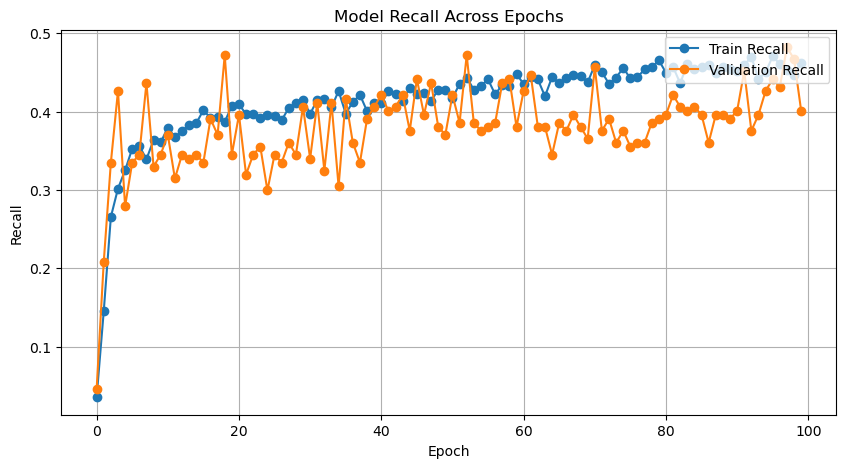

In [56]:
# Plotting train recall vs validation recall

plt.figure(figsize=(10, 5))
plt.plot(history_2.history['recall'], 'o-', label='Train Recall')
plt.plot(history_2.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [57]:
# Predicting the training data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_train_pred = model_2.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

250/250 [==============================] - 0s 283us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [58]:
# Predicting the validation data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_val_pred = model_2.predict(X_val)
y_val_pred = (y_val_pred > 0.5)  
print(y_val_pred[:10])

32/32 [==============================] - 0s 408us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [59]:
model_name = "NN with Adam & Dropout"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [60]:
# Classification report for model performance on training data

cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.96      0.92      6370
           1       0.76      0.46      0.57      1630

    accuracy                           0.86      8000
   macro avg       0.82      0.71      0.75      8000
weighted avg       0.85      0.86      0.85      8000



In [61]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       803
           1       0.71      0.40      0.51       197

    accuracy                           0.85      1000
   macro avg       0.79      0.68      0.71      1000
weighted avg       0.84      0.85      0.83      1000



#### Confusion Matrix

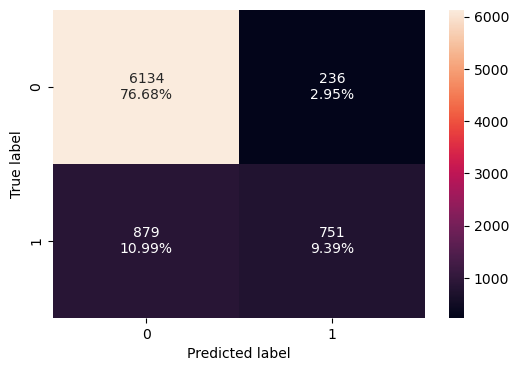

In [62]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train, y_train_pred)

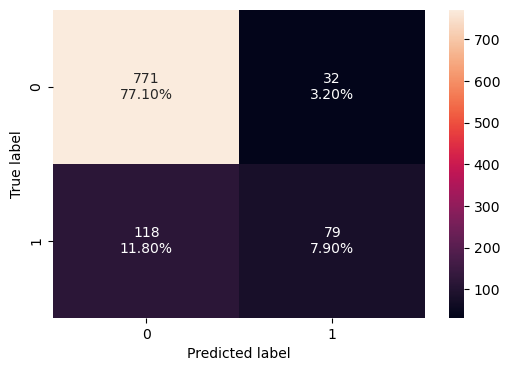

In [63]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

In [ ]:
# Apply SMOTE only on the training set

smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verify the distribution after resampling

from collections import Counter
print(f"Training set distribution before SMOTE: {Counter(y_train)}")
print(f"Training set distribution after SMOTE: {Counter(y_train_resampled)}")
print(f"Validation set distribution: {Counter(y_val)}")

In [ ]:

# Compile the model

optimizer = Adam(learning_rate=0.0009)

model.compile(optimizer=optimizer, 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

# Early stopping to avoid overfitting

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)

# Fit the model

history = model.fit(X_train_resampled, y_train_resampled, 
                    batch_size=64, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

# Plotting train loss vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plotting train recall vs validation recall
plt.figure(figsize=(10, 5))
plt.plot(history.history['recall'], 'o-', label='Train Recall')
plt.plot(history.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

y_train_pred = model.predict(X_train_resampled)
y_train_pred = (y_train_pred > 0.5)

y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5)

print(classification_report(y_train_resampled, y_train_pred))
print(classification_report(y_val, y_val_pred))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Verify and convert data if needed
def ensure_numpy(data):
    return data.values if isinstance(data, pd.DataFrame) else data

X_train_resampled = ensure_numpy(X_train_resampled)
y_train_resampled = ensure_numpy(y_train_resampled)
X_val = ensure_numpy(X_val)
y_val = ensure_numpy(y_val)

# Print shapes to verify
print("Shapes:")
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

# Initializing the neural network
model = Sequential()
model.add(Dense(11, activation='relu', input_dim=X_train_resampled.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0009)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Recall'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(X_train_resampled, y_train_resampled, batch_size=64, epochs=50, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plotting train loss vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], 'o-', label='Train Loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plotting train recall vs validation recall
plt.figure(figsize=(10, 5))
plt.plot(history.history['recall'], 'o-', label='Train Recall')
plt.plot(history.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Evaluating the model
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train_resampled)
y_train_pred = (y_train_pred > 0.5)

y_val_pred = model.predict(X_val)
y_val_pred = (y_val_pred > 0.5)

print(classification_report(y_train_resampled, y_train_pred))
print(classification_report(y_val, y_val_pred))


### Neural Network with Balanced Data (by applying SMOTE) and SGD Optimizer

In [68]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [65]:
# Apply SMOTE only on the training set

smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [69]:
# Verify the distribution after resampling

print(f"Training set distribution before SMOTE: {Counter(y_train)}")
print(f"Training set distribution after SMOTE: {Counter(y_train_resampled)}")
print(f"Validation set distribution: {Counter(y_val)}")

Training set distribution before SMOTE: Counter({0: 6370, 1: 1630})
Training set distribution after SMOTE: Counter({0: 6370, 1: 6370})
Validation set distribution: Counter({0: 803, 1: 197})


In [70]:
# Initializing the neural network

model_3 = Sequential()

# Input layer consisting of 11 neurons

model_3.add(Dense(11, activation='relu', input_dim=X_train_resampled.shape[1]))

# First hidden layer consisting of 128 neurons

model_3.add(Dense(128, activation='relu'))

# Second hidden layer consisting of 256 neurons

model_3.add(Dense(256, activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_3.add(Dense(1, activation='sigmoid'))

In [71]:
# Adam will be used as the optimizer for this fourth model

optimizer = Adam(learning_rate=0.0009)

metric = keras.metrics.Recall()

In [72]:
# Compile the model

model_3.compile(optimizer=optimizer,
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Recall'])

In [74]:
# Early stopping to avoid overfitting

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True)

In [80]:
# Display a summary of the structure of the model with number of total layers and parameters

model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dense_1 (Dense)             (None, 128)               1536      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 34,938
Trainable params: 34,938
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Fit the model to the training data across 50 epochs

history_3 = model_3.fit(X_train_resampled, y_train_resampled, 
                    batch_size=64, 
                    epochs=50, 
                    verbose=1, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])

Epoch 1/50
200/200 [==============================] - 0s 1000us/step - loss: 0.5589 - accuracy: 0.7107 - recall: 0.7182 - val_loss: 0.4892 - val_accuracy: 0.7590 - val_recall: 0.7208
Epoch 2/50
200/200 [==============================] - 0s 746us/step - loss: 0.4908 - accuracy: 0.7538 - recall: 0.7702 - val_loss: 0.4668 - val_accuracy: 0.7830 - val_recall: 0.7462
Epoch 3/50
200/200 [==============================] - 0s 760us/step - loss: 0.4592 - accuracy: 0.7767 - recall: 0.7818 - val_loss: 0.4794 - val_accuracy: 0.7680 - val_recall: 0.7563
Epoch 4/50
200/200 [==============================] - 0s 747us/step - loss: 0.4456 - accuracy: 0.7825 - recall: 0.7845 - val_loss: 0.5212 - val_accuracy: 0.7400 - val_recall: 0.7817
Epoch 5/50
200/200 [==============================] - 0s 738us/step - loss: 0.4383 - accuracy: 0.7867 - recall: 0.7848 - val_loss: 0.4341 - val_accuracy: 0.7930 - val_recall: 0.6802
Epoch 6/50
200/200 [==============================] - 0s 745us/step - loss: 0.4278 - accu

#### Loss Function

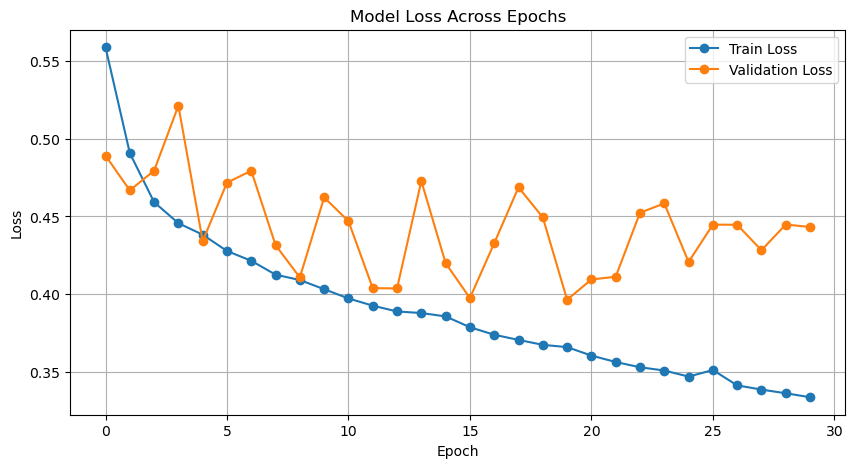

In [77]:
# Plotting train loss vs validation loss

plt.figure(figsize=(10, 5))
plt.plot(history_3.history['loss'], 'o-', label='Train Loss')
plt.plot(history_3.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

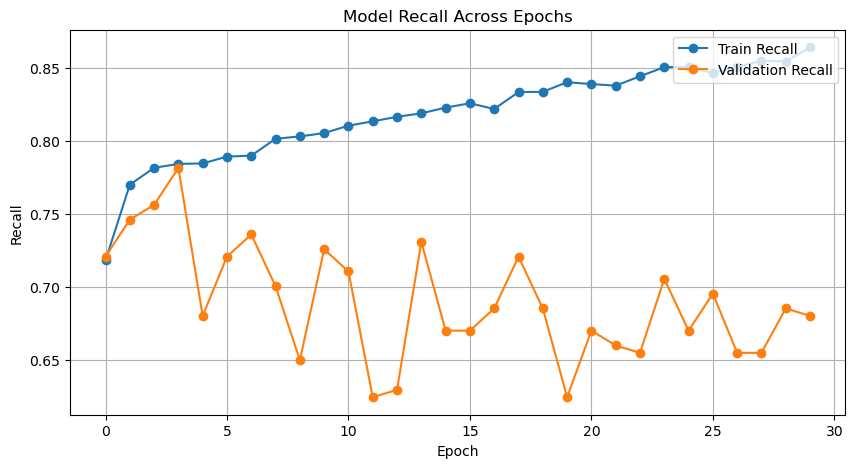

In [79]:
# Plotting train recall vs validation recall

plt.figure(figsize=(10, 5))
plt.plot(history_3.history['recall'], 'o-', label='Train Recall')
plt.plot(history_3.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [81]:
# Predicting the training data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_train_pred = model_3.predict(X_train_resampled)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

399/399 [==============================] - 0s 253us/step
[[False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [82]:
# Predicting the validation data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_val_pred = model_3.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
print(y_val_pred[:10])

32/32 [==============================] - 0s 312us/step
[[ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


#### Classification Report

In [83]:
# Classification report for model performance on training data

cr = classification_report(y_train_resampled, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      6370
           1       0.87      0.80      0.83      6370

    accuracy                           0.84     12740
   macro avg       0.84      0.84      0.84     12740
weighted avg       0.84      0.84      0.84     12740



In [84]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       803
           1       0.54      0.62      0.58       197

    accuracy                           0.82      1000
   macro avg       0.72      0.75      0.73      1000
weighted avg       0.83      0.82      0.83      1000



#### Confusion Matrix

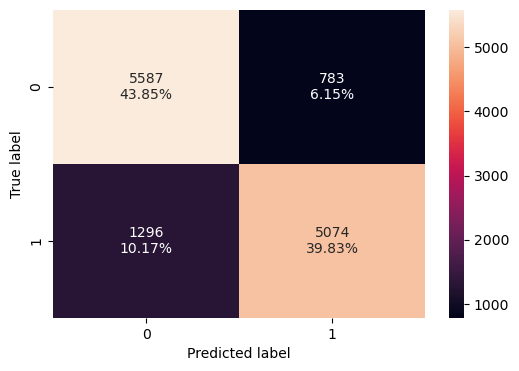

In [85]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train_resampled, y_train_pred)

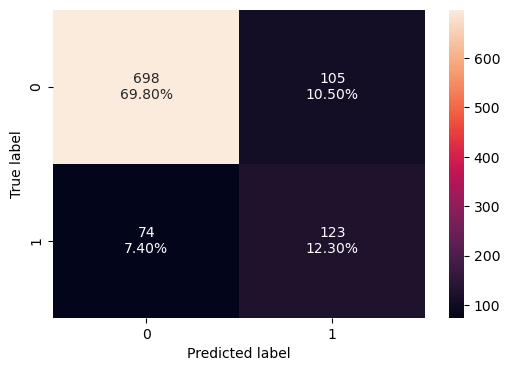

In [86]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

In [88]:
model_name = "NN with SMOTE & Adam"

train_metric_df.loc[model_name] = recall_score(y_train_resampled,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

### Neural Network with Balanced Data (by applying SMOTE) and Adam Optimizer

In [89]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [90]:
# Initializing the model

model_4 = Sequential()

# Input layer consisting of 11 neurons

model_4.add(Dense(11, activation='relu', input_dim = X_train_resampled.shape[1]))

# First hidden layer consisting of 128 neurons

model_4.add(Dense(128,activation='relu'))

# Second hidden layer consisting of 64 neurons

model_4.add(Dense(64,activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_4.add(Dense(1, activation = 'sigmoid'))

In [91]:
# Adam will be used as the optimizer for this fifth model with its learning rate set to 0.001

optimizer = Adam(learning_rate=0.001)

metric = keras.metrics.Recall()

In [92]:
# Compile the model with binary cross entropy as loss function and recall as the metric

model_4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=[metric])

In [93]:
# Display a summary of the structure of the model with number of total layers and parameters

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dense_1 (Dense)             (None, 128)               1536      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,978
Trainable params: 9,978
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Fit the model to the training data across 50 epochs

history_4 = model_4.fit(
    X_train_resampled, y_train_resampled,
    batch_size=32, 
    epochs=50, 
    verbose=1,
    validation_data = (X_val,y_val))

Epoch 1/50
399/399 [==============================] - 0s 683us/step - loss: 0.5555 - recall: 0.7155 - val_loss: 0.4995 - val_recall: 0.7462
Epoch 2/50
399/399 [==============================] - 0s 561us/step - loss: 0.4802 - recall: 0.7713 - val_loss: 0.4686 - val_recall: 0.7614
Epoch 3/50
399/399 [==============================] - 0s 544us/step - loss: 0.4523 - recall: 0.7766 - val_loss: 0.4811 - val_recall: 0.7665
Epoch 4/50
399/399 [==============================] - 0s 573us/step - loss: 0.4397 - recall: 0.7799 - val_loss: 0.4752 - val_recall: 0.7360
Epoch 5/50
399/399 [==============================] - 0s 579us/step - loss: 0.4316 - recall: 0.7863 - val_loss: 0.4387 - val_recall: 0.6802
Epoch 6/50
399/399 [==============================] - 0s 567us/step - loss: 0.4258 - recall: 0.7890 - val_loss: 0.4480 - val_recall: 0.6853
Epoch 7/50
399/399 [==============================] - 0s 552us/step - loss: 0.4175 - recall: 0.7928 - val_loss: 0.4208 - val_recall: 0.6294
Epoch 8/50
399/399 [

#### Loss Function

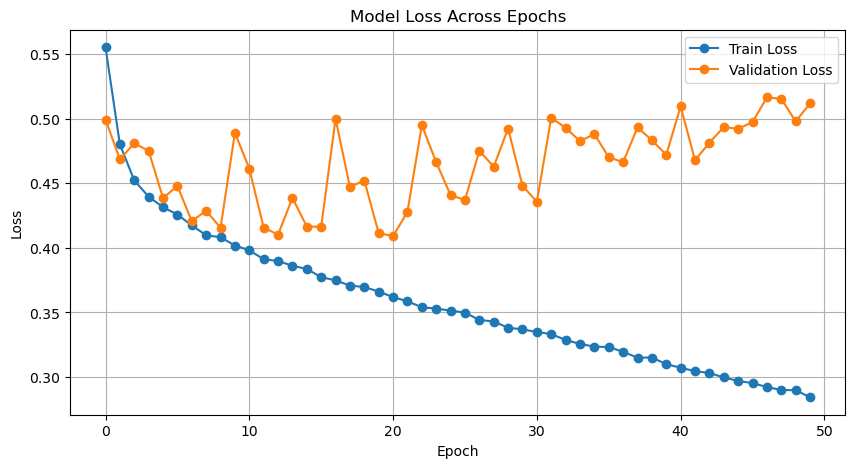

In [95]:
# Plotting train loss vs validation loss

plt.figure(figsize=(10, 5))
plt.plot(history_4.history['loss'], 'o-', label='Train Loss')
plt.plot(history_4.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

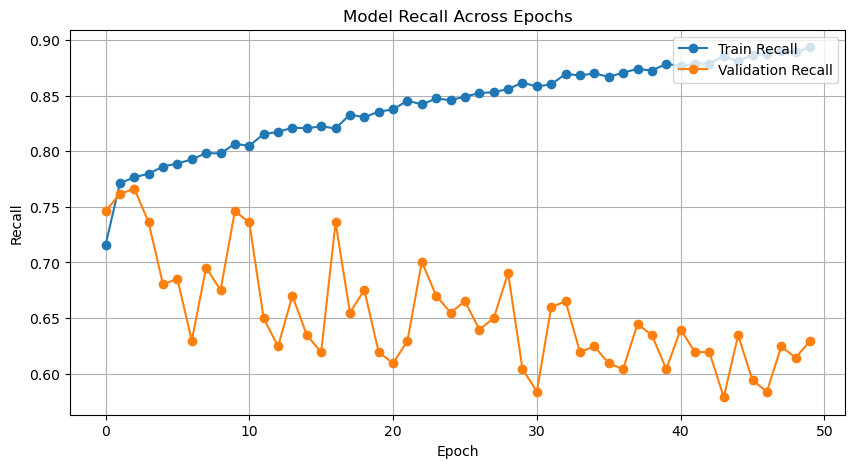

In [96]:
# Plotting train recall vs validation recall

plt.figure(figsize=(10, 5))
plt.plot(history_4.history['recall'], 'o-', label='Train Recall')
plt.plot(history_4.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [97]:
# Predicting the training data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_train_pred = model_4.predict(X_train_resampled)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

399/399 [==============================] - 0s 243us/step
[[False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [98]:
# Predicting the validation data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_val_pred = model_4.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
print(y_val_pred[:10])

32/32 [==============================] - 0s 279us/step
[[ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]]


#### Classification Report

In [99]:
# Classification report for model performance on training data

cr = classification_report(y_train_resampled, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      6370
           1       0.87      0.91      0.89      6370

    accuracy                           0.89     12740
   macro avg       0.89      0.89      0.89     12740
weighted avg       0.89      0.89      0.89     12740



In [100]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.83      0.87       803
           1       0.48      0.63      0.55       197

    accuracy                           0.79      1000
   macro avg       0.69      0.73      0.71      1000
weighted avg       0.82      0.79      0.80      1000



#### Confusion Matrix

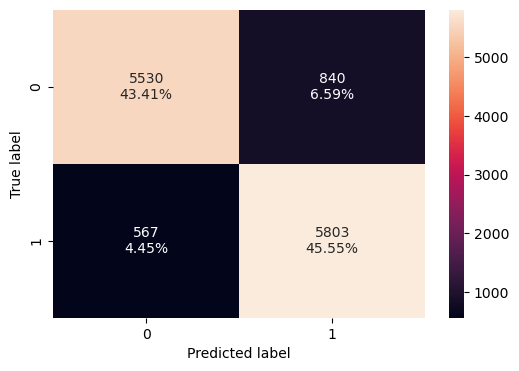

In [101]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train_resampled, y_train_pred)

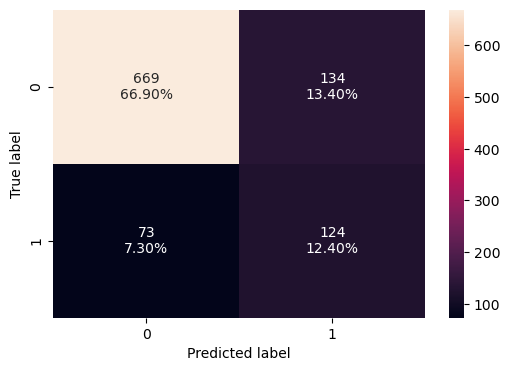

In [102]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

### Neural Network with Balanced Data (by applying SMOTE), Adam Optimizer, and Dropout

In [164]:
backend.clear_session()

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [165]:
# Initializing the model

model_5 = Sequential()

# Input layer consisting of 11 neurons

model_5.add(Dense(11, activation='relu', input_dim = X_train_resampled.shape[1]))

# Dropout rate of 0.2 on input layer

model_5.add(Dropout(0.2))

# First hidden layer consisting of 128 neurons

model_5.add(Dense(128,activation='relu'))

# Dropout rate of 0.2 on first hidden layer

model_5.add(Dropout(0.2))

# Second hidden layer consisting of 64 neurons

model_5.add(Dense(64,activation='relu'))

# Output layer consisting of 1 neuron using the sigmoid activation function for binary output

model_5.add(Dense(1, activation = 'sigmoid'))

In [166]:
# Adam will be used as the optimizer for this sixth model with its learning rate set to 0.001

optimizer = Adam(learning_rate=0.0001)

metric = keras.metrics.Recall()

In [167]:
# Compile the model with binary cross entropy as loss function and recall as the metric

model_5.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=[metric])

In [168]:
# Display a summary of the structure of the model with number of total layers and parameters

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                121       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               1536      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,978
Trainable params: 9,978
Non-trainabl

In [169]:
# Fit the model to the training data across 50 epochs

history_5 = model_5.fit(
    X_train_resampled,y_train_resampled,
    batch_size=32, 
    epochs=50,
    verbose=1,
    validation_data = (X_val,y_val))

Epoch 1/50
399/399 [==============================] - 0s 718us/step - loss: 0.6724 - recall: 0.4937 - val_loss: 0.6212 - val_recall: 0.5787
Epoch 2/50
399/399 [==============================] - 0s 592us/step - loss: 0.6282 - recall: 0.6327 - val_loss: 0.5974 - val_recall: 0.6853
Epoch 3/50
399/399 [==============================] - 0s 589us/step - loss: 0.6036 - recall: 0.6830 - val_loss: 0.5847 - val_recall: 0.7157
Epoch 4/50
399/399 [==============================] - 0s 584us/step - loss: 0.5921 - recall: 0.7093 - val_loss: 0.5562 - val_recall: 0.7005
Epoch 5/50
399/399 [==============================] - 0s 584us/step - loss: 0.5820 - recall: 0.7111 - val_loss: 0.5563 - val_recall: 0.7310
Epoch 6/50
399/399 [==============================] - 0s 593us/step - loss: 0.5718 - recall: 0.7237 - val_loss: 0.5496 - val_recall: 0.7157
Epoch 7/50
399/399 [==============================] - 0s 599us/step - loss: 0.5665 - recall: 0.7275 - val_loss: 0.5436 - val_recall: 0.7157
Epoch 8/50
399/399 [

#### Loss Function

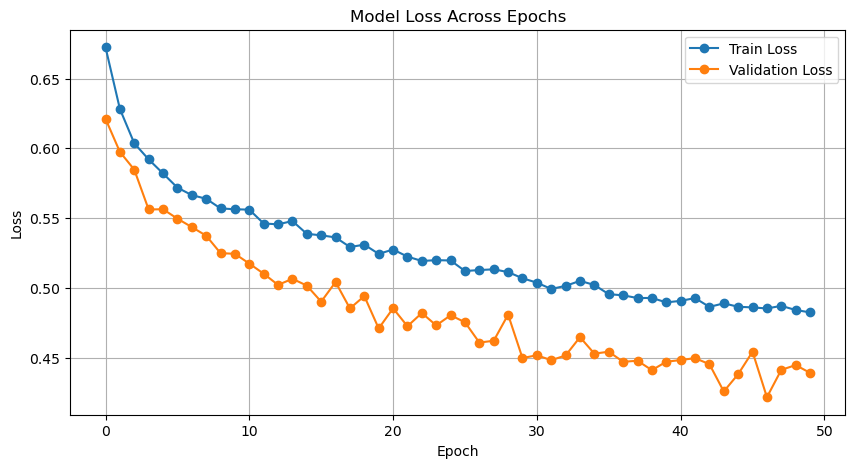

In [170]:
# Plotting train loss vs validation loss 

plt.figure(figsize=(10, 5))
plt.plot(history_5.history['loss'], 'o-', label='Train Loss')
plt.plot(history_5.history['val_loss'], 'o-', label='Validation Loss')
plt.title('Model Loss Across Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

#### Recall

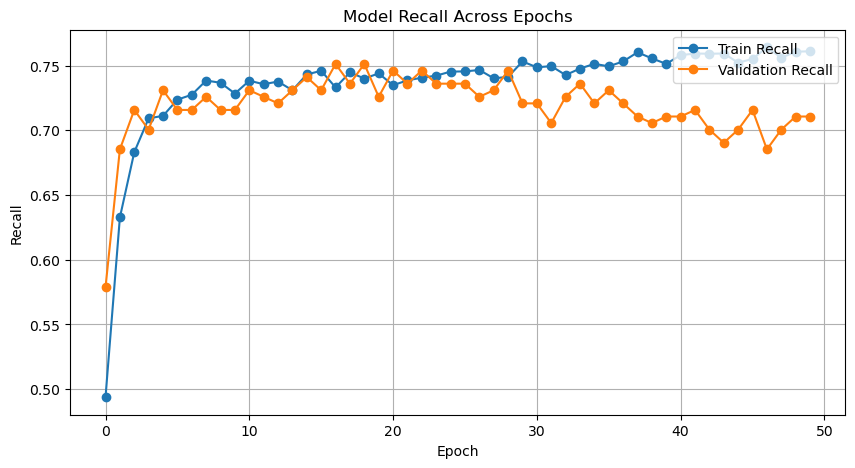

In [171]:
# Plotting train recall vs validation recall 

plt.figure(figsize=(10, 5))
plt.plot(history_5.history['recall'], 'o-', label='Train Recall')
plt.plot(history_5.history['val_recall'], 'o-', label='Validation Recall')
plt.title('Model Recall Across Epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [172]:
# Predicting the training data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_train_pred = model_5.predict(X_train_resampled)
y_train_pred = (y_train_pred > 0.5)
print(y_train_pred[:10])

399/399 [==============================] - 0s 237us/step
[[False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]]


In [173]:
# Predicting the validation data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_val_pred = model_5.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
print(y_val_pred[:10])

32/32 [==============================] - 0s 236us/step
[[False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]]


In [174]:
model_name = "NN with SMOTE,Adam & Dropout"

train_metric_df.loc[model_name] = recall_score(y_train_resampled,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

#### Classification Report

In [175]:
# Classification report for model performance on training data

cr = classification_report(y_train_resampled, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      6370
           1       0.79      0.77      0.78      6370

    accuracy                           0.78     12740
   macro avg       0.78      0.78      0.78     12740
weighted avg       0.78      0.78      0.78     12740



In [176]:
# Classification report for model performance on validation data

cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       803
           1       0.48      0.71      0.57       197

    accuracy                           0.79      1000
   macro avg       0.70      0.76      0.72      1000
weighted avg       0.83      0.79      0.80      1000



#### Confusion Matrix

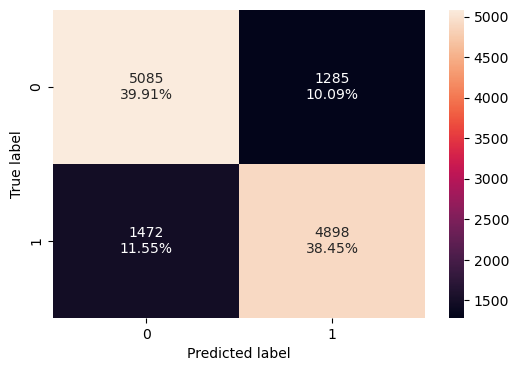

In [177]:
# Display confusion matrix for model results on training data

make_confusion_matrix(y_train_resampled, y_train_pred)

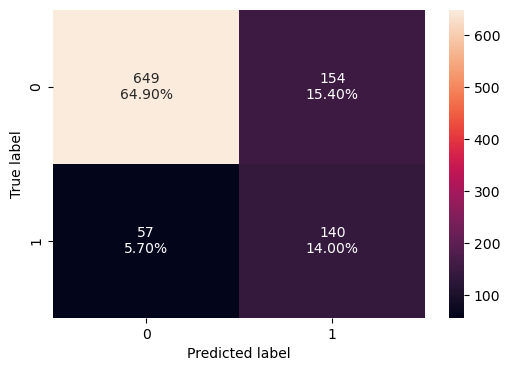

In [178]:
# Display confusion matrix for model results on validation data

make_confusion_matrix(y_val, y_val_pred)

## Model Performance Comparison and Final Model Selection

In [158]:
print("Training performance comparison")
train_metric_df

Training performance comparison


,recall
NN with SGD,0.431288
NN with Adam,0.369939
NN with Adam & Dropout,0.460736
NN with SMOTE & Adam,0.796546
"NN with SMOTE,Adam & Dropout",0.822449


In [159]:
print("Validation set performance comparison")
valid_metric_df

Validation set performance comparison


,recall
NN with SGD,0.446701
NN with Adam,0.340102
NN with Adam & Dropout,0.401015
NN with SMOTE & Adam,0.624365
"NN with SMOTE,Adam & Dropout",0.736041


In [160]:
train_metric_df - valid_metric_df

,recall
NN with SGD,-0.015412
NN with Adam,0.029837
NN with Adam & Dropout,0.059721
NN with SMOTE & Adam,0.172181
"NN with SMOTE,Adam & Dropout",0.086408


In [161]:
# Predicting the test data outcomes and displaying the first 10 outcomes using 0.5 as the threshold

y_test_pred = model_5.predict(X_test)   
y_test_pred = (y_test_pred > 0.5)
print(y_test_pred[:10])

32/32 [==============================] - 0s 283us/step
[[False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]]


In [162]:
# Classification report for model performance on test data

cr=classification_report(y_test,y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       790
           1       0.44      0.75      0.56       210

    accuracy                           0.75      1000
   macro avg       0.68      0.75      0.69      1000
weighted avg       0.82      0.75      0.77      1000



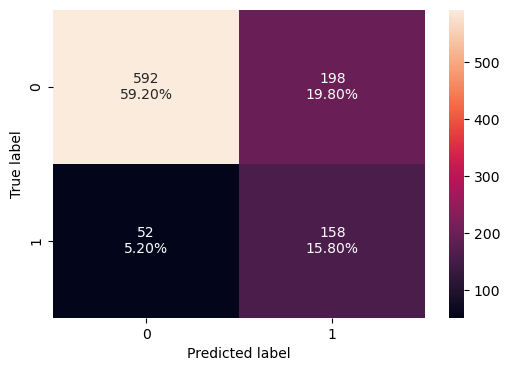

In [163]:
# Display confusion matrix for model results on test data

make_confusion_matrix(y_test,y_test_pred)

## Actionable Insights and Business Recommendations

**Feature Engineering:**

Investigate creating interaction terms or polynomial features that might help in capturing non-linear relationships more effectively.

Consider more detailed segmentation of continuous variables, like salary or balance, using binning or categorization to capture nuances in customer behavior at different levels.

**Model Enhancements:**

Experiment with different architectures for the neural network, perhaps varying the number of layers or the number of neurons per layer.

Try using different activation functions to see if they affect model performance, especially in capturing complex patterns in the data.

**Advanced Techniques:**

Implement techniques like cross-validation during training to ensure the model's stability and robustness across different subsets of the data.

Explore advanced algorithms like Gradient Boosting or XGBoost, which may provide more predictive accuracy than neural networks.

**Targeted Customer Engagement:**

Develop personalized retention strategies based on the characteristics associated with high churn risk, such as low balances or single product usage.

**Product and Service Improvements:**

Enhance product offerings and customer service for segments identified as having higher churn, such as certain geographic areas or demographic groups.

**Customer Feedback:**

Regularly gather and analyze customer feedback, especially from those who churn, to continuously adapt and improve services.